In [ ]:
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import argparse
import pandas as pd


In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml

--2021-07-06 01:05:38--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341406 (333K) [text/plain]
Saving to: ‘haarcascade_eye.xml’

haarcascade_eye.xml 100%[===================>] 333.40K  --.-KB/s    in 0.04s   

2021-07-06 01:05:39 (8.63 MB/s) - ‘haarcascade_eye.xml’ saved [341406/341406]



In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml


--2021-07-06 01:05:41--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2021-07-06 01:05:41 (18.6 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
eye_cascade = cv2.CascadeClassifier('/content/haarcascade_eye.xml')
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [ ]:
def rotate(image):
  l1=[]
  eyes = eye_cascade.detectMultiScale(image)
  for (ex,ey,ew,eh) in eyes:
      l1.append((ex+ew/2,ey+eh/2))

  if(len(l1)==2):
    dist_x = l1[1][0]-l1[0][0]
    dist_y = l1[1][1] - l1[0][1]
    if dist_x<0:
      dist_y = -dist_y
    dist_x = np.abs(dist_x)
    angle = np.arctan(dist_y/(dist_x+1e-8)) * 180/3.14
    M = cv2.getRotationMatrix2D((240, 240), angle, 1.0)
    image = cv2.warpAffine(image, M,(480,480))
  return image


In [ ]:
def crop(image,x_factor=2.1,y_factor=3.2):
  l1=[]
  eyes = eye_cascade.detectMultiScale(image)
  for (ex,ey,ew,eh) in eyes:
      l1.append((ex+ew/2,ey+eh/2))
  if(len(l1)==2):
    dist = np.sqrt((l1[0][0]-l1[1][0])**2+(l1[0][1]-l1[1][1])**2)
    center_x = image.shape[1]//2
    center_y = image.shape[0]//2
    shift_x = int(dist*x_factor)//2
    shift_y = int(dist*y_factor)//2
    start_x = center_x - shift_x
    start_x = max(start_x,0)
    end_x = center_x+shift_x
    end_x = min(end_x,image.shape[1])
    start_y = center_y - shift_y
    start_y = max(start_y,0)
    end_y = center_y + shift_y
    end_y = min(end_y,image.shape[0])
    image = image[start_y:end_y,start_x:end_x]
  return image

In [ ]:
def extract(video,folder,n):
    vidcap = cv2.VideoCapture(video)
    total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    frames_step = total_frames//n
    j=0
    for i in range(n):
        #here, we set the parameter 1 which is the frame number to the frame (i*frames_step)
        vidcap.set(1,i*frames_step)
        success,image = vidcap.read()
        faces = face_cascade.detectMultiScale(image)
        if(len(faces)==1):
            for (x,y,w,h) in faces:
                image = image[y:y+h,x:x+h]
            image = cv2.resize(image,(480,480), interpolation = cv2.INTER_AREA)
            image = rotate(image)
            image = crop(image)
            image = cv2.resize(image,(48,48), interpolation = cv2.INTER_AREA)
            image_path = folder+"/"+str(i)+".jpg"
            cv2.imwrite(image_path,image)
            j+=1
    vidcap.release()
    return j

In [ ]:
def main_func(src_path,dest_path,n):
    if os.path.exists(src_path) ==False:
        print("No such Folder exists. Check your source folder")
        exit(0)
    if os.path.exists(dest_path)==False:
        os.mkdir(dest_path)
    subjects = os.listdir(src_path)
    for subject in subjects:
        i=0
        j=0
        print("Extracting Frames for "+subject+"...")
        dest_subject = dest_path+"/"+subject
        os.mkdir(dest_subject)
        src_subject = src_path+"/"+subject
        vid_loc = src_subject+"/avi"
        emotion_loc = src_subject+"/emotion"
        videos = os.listdir(vid_loc)
        for video in videos:
            i+=1
            src_vid = vid_loc+"/"+video
            dest_vid = dest_subject+"/"+video[:-4]
            os.mkdir(dest_vid)
            dest_vid_image = dest_vid+"/frames"
            os.mkdir(dest_vid_image)
            shutil.copyfile(emotion_loc+"/"+video[:-4]+".txt", dest_vid+"/emotion.txt")
            num = extract(src_vid,dest_vid_image,n)
            j+=num
        print(i,"Videos Found,",j,"Frames Extracted")
    print("Extraction Completed!")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
src='/content/drive/MyDrive/BAUM-2_Dataset'
des='/content/drive/MyDrive/Extracted'
frames=12

In [ ]:
main_func(src,des,frames)

Extracting Frames for S281...
3 Videos Found, 36 Frames Extracted
Extracting Frames for S279...
2 Videos Found, 24 Frames Extracted
Extracting Frames for S278...
3 Videos Found, 36 Frames Extracted
Extracting Frames for S282...
4 Videos Found, 48 Frames Extracted
Extracting Frames for S283...
1 Videos Found, 12 Frames Extracted
Extracting Frames for S277...
1 Videos Found, 12 Frames Extracted
Extracting Frames for S280...
9 Videos Found, 107 Frames Extracted
Extracting Frames for S286...
2 Videos Found, 24 Frames Extracted
Extracting Frames for S285...
2 Videos Found, 24 Frames Extracted
Extracting Frames for S284...
2 Videos Found, 24 Frames Extracted
Extracting Frames for S268...
5 Videos Found, 57 Frames Extracted
Extracting Frames for S274...
7 Videos Found, 84 Frames Extracted
Extracting Frames for S270...
15 Videos Found, 169 Frames Extracted
Extracting Frames for S272...
2 Videos Found, 21 Frames Extracted
Extracting Frames for S269...
9 Videos Found, 102 Frames Extracted
Extrac

In [ ]:
def get_emotion(loc):
    file_emotion = open(loc,'r')
    line = file_emotion.readline()
    file_emotion.close()
    return line.strip()[0]


def create_list(main_dir,file_loc = "main.txt"):
    if os.path.exists(main_dir)==False:
        print("Not a valid path")
        exit(0)
    file1 = open(file_loc,'w')
    subjects = sorted(os.listdir(main_dir))
    print(subjects)
    i=0
    for subject in subjects:
        sub_loc = main_dir+"/"+subject
        print(sub_loc)
        videos = sorted(os.listdir(sub_loc))
        for video in videos:
            video_loc = sub_loc+"/"+video
            #print(video_loc)
            videos1 = sorted(os.listdir(video_loc))
            for video11 in videos1:
              emotion = get_emotion(video_loc+'/'+video11+"/emotion.txt")
              frames = sorted([int(x[:-4]) for x in os.listdir(video_loc+'/'+video11+"/frames")])
              #for frame in frames:
              file1.write(video_loc+'/'+video11+"/frames/"+","+emotion+'\n')
              i+=1
    print("Total Number of Frames:",i)
    file1.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
src='/content/drive/MyDrive/ds'
dst='/content/drive/MyDrive/final4.txt'

In [ ]:
create_list(src,dst)

['dataset']
/content/drive/MyDrive/ds/dataset
Total Number of Frames: 1047


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/finaldata.csv")
df

,frames,emotion
0,/content/drive/MyDrive/ds/dataset/S001/001/fra...,7
1,/content/drive/MyDrive/ds/dataset/S002/001/fra...,2
2,/content/drive/MyDrive/ds/dataset/S002/002/fra...,5
3,/content/drive/MyDrive/ds/dataset/S003/001/fra...,5
4,/content/drive/MyDrive/ds/dataset/S004/001/fra...,5
...,...,...
1042,/content/drive/MyDrive/ds/dataset/S284/002/fra...,7
1043,/content/drive/MyDrive/ds/dataset/S285/001/fra...,0
1044,/content/drive/MyDrive/ds/dataset/S285/002/fra...,0
1045,/content/drive/MyDrive/ds/dataset/S286/001/fra...,0


In [ ]:
import numpy as np
import pandas as pd
import itertools 
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Conv2D, Input, Dense, MaxPool2D,BatchNormalization,Flatten,ZeroPadding2D,Activation,Dropout,LSTM
from keras.layers import TimeDistributed
from keras.models import Model,Sequential
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
%matplotlib inline

In [ ]:
x = np.array(df['frames'])
print(len(x))
y = pd.get_dummies(df['emotion']).to_numpy()

1047


In [ ]:
print(y)

[[0 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


In [ ]:
y.shape

(1047, 8)

In [ ]:
import cv2
import numpy as np

count = len(x)

data1 =[]
ls=[]
index=[]
c=0
print("data loading. ")
for j in range(1047):
    for i in range(12):
        arr1 = cv2.imread(x[j]+str(i)+'.jpg',cv2.IMREAD_GRAYSCALE)
        if arr1 is None:
          break
        #print(arr1.size)

        #print(j)
        data1.append(arr1)

        #print('\r{}%'.format(j/len(x)*100),end='')
    if(len(data1)!=12):
     index.append(j)

     #print(j)
     data1=[]
     continue
     c=c+1
     
    #print(len(data1))
    data1=np.array(data1)
    ls.append(data1)
    data1=[]
print(c)
    #print(c)
    #print(data1[0].shape)
    #print(len(ls))
#data = np.delete(data,0)
#data2 = data2.reshape(883,12,48,48,1)
#print('\r100%\nFinal Shape: ',data.shape)

data loading. 
0


In [ ]:
print(len(index))

164


In [ ]:
y=np.delete(y,index,axis=0)

In [ ]:
print(y)

[[0 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


In [ ]:
y.shape

(883, 8)

In [ ]:
print(len(ls))

883


In [ ]:
print(ls[8].shape)

(12, 48, 48)


In [ ]:
data2 = data2.reshape(883,12,48,48,1)

In [ ]:
data2 = np.array(ls)

In [ ]:
data2.shape

(883, 12, 48, 48, 1)

In [ ]:
print(len(x))

1047


In [ ]:
def classifierModel(X_input):
  X=TimeDistributed(Conv2D(64, (3,3), strides=(2,2), name='conv1', activation='relu'))(X_input)
  X=TimeDistributed(MaxPool2D((3,3),strides=(2,2),name='maxpool2'))(X)
  X = TimeDistributed(BatchNormalization())(X)

  X = TimeDistributed(Conv2D(96,(1,1),name='conv4',activation='relu'))(X)
  X = TimeDistributed(MaxPool2D((3,3),strides=(1,1),name='max_pool3'))(X)
  X = TimeDistributed(Conv2D(208,(3,3),name='conv5',activation='relu'))(X)
  X = TimeDistributed(Conv2D(64,(1,1),name='conv6',activation='relu'))(X)

  X= TimeDistributed(Conv2D(96,(1,1),name='conv7',activation='relu'))(X)
  X= TimeDistributed(MaxPool2D((3,3),strides=(1,1),name='max_pool4'))(X)
  X = TimeDistributed(Conv2D(208, (3,3),name='conv8',activation='relu'))(X)
  X = TimeDistributed(Conv2D(64,(1,1),name='conv9',activation='relu'))(X)

  out = TimeDistributed(Flatten())(X)
  out = TimeDistributed(Dropout(0.5))(out)
  out = TimeDistributed(Dense(128,activation = 'linear'))(out)


  return out

In [ ]:
def LSTM_model(input_shape):
  X_input = Input(shape = input_shape)
  X = classifierModel(X_input)
  X = LSTM(128)(X)
  X = Dense(8,activation='softmax',kernel_regularizer=keras.regularizers.l1())(X)
  model = Model(inputs = X_input,outputs = X)
  return model

In [ ]:
model1 = LSTM_model((12,48,48,1))

In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 12, 48, 48, 1)]   0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 12, 23, 23, 64)    640       
_________________________________________________________________
time_distributed_29 (TimeDis (None, 12, 11, 11, 64)    0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 12, 11, 11, 64)    256       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 12, 11, 11, 96)    6240      
_________________________________________________________________
time_distributed_32 (TimeDis (None, 12, 9, 9, 96)      0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 12, 7, 7, 208)     1799

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data2, y, test_size=0.1, random_state=42)

In [ ]:
print('X_train: ',X_train.shape,'\nX_test: ',X_test.shape,'\ny_train: ',y_train.shape,'\ny_test: ',y_test.shape)

X_train:  (794, 12, 48, 48, 1) 
X_test:  (89, 12, 48, 48, 1) 
y_train:  (794, 8) 
y_test:  (89, 8)


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
history1=model1.fit(X_train,y_train,epochs=50,batch_size = 50,validation_data=(X_test,y_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
16/16 [==============================] - 2s 101ms/step - loss: 1.9588 - accuracy: 0.3451 - val_loss: 2.0984 - val_accuracy: 0.2022
Epoch 2/50
16/16 [==============================] - 1s 70ms/step - loss: 1.9253 - accuracy: 0.3438 - val_loss: 2.0652 - val_accuracy: 0.2247
Epoch 3/50
16/16 [==============================] - 1s 68ms/step - loss: 1.8918 - accuracy: 0.3602 - val_loss: 2.0544 - val_accuracy: 0.2135
Epoch 4/50
16/16 [==============================] - 1s 70ms/step - loss: 1.8430 - accuracy: 0.3929 - val_loss: 2.1052 - val_accuracy: 0.2247
Epoch 5/50
16/16 [==============================] - 1s 71ms/step - loss: 1.8233 - accuracy: 0.3967 - val_loss: 2.0251 - val_accuracy: 0.2697
Epoch 6/50
16/16 [==============================] - 1s 71ms/step - loss: 1.7921 - accuracy: 0.3980 - val_loss: 2.0370 - val_accuracy: 0.2697
Epoch 7/50
16/16 [==============================] - 1s 69ms/step - loss: 1.7631 - accuracy: 0.4358 - val_loss: 2.0518 - val_accuracy: 0.2697
Epoch 8/50
1

In [ ]:
from keras.layers import Conv3D,MaxPool3D
def c3d_model(input_shape):
  input = Input(shape = input_shape)
  X = Conv3D(64,(1,3,3),activation = 'relu')(input)
  X = MaxPool3D((1,2,2),strides=(1,2,2))(X)
  X = Conv3D(128,(1,3,3),activation='relu')(X)
  X = MaxPool3D((1,2,2),strides=(2,2,2))(X)
  X = Conv3D(128,(1,1,1),activation='relu')(X)
  X = Conv3D(256,(1,1,1),activation = 'relu')(X)
  X = MaxPool3D((2,2,2),strides=(2,2,2))(X)
  X = Conv3D(256,(1,1,1),activation='relu')(X)
  X = Conv3D(512,(1,1,1),activation='relu')(X)
  X = MaxPool3D((2,2,2),strides=(2,2,2))(X)
  X = Conv3D(512,(1,1,1),activation='relu')(X)
  X = Conv3D(512,(1,1,1),activation='relu')(X)
  X = MaxPool3D((1,1,1),strides=(2,2,2))(X)
  X = Flatten()(X)
  X = Dense(4096)(X)
  X = Dropout(0.5)(X)
  X = Dense(4096)(X)
  X = Dropout(0.5)(X)
  out = Dense(8,activation='softmax')(X)
  model = Model(inputs = input,outputs = out)
  return model

In [ ]:
c3d = c3d_model((12,48,48,1))

In [ ]:
c3d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history2=c3d.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/50
25/25 [==============================] - 4s 100ms/step - loss: 5.2079 - accuracy: 0.1718 - val_loss: 2.1114 - val_accuracy: 0.0674
Epoch 2/50
25/25 [==============================] - 2s 75ms/step - loss: 2.0065 - accuracy: 0.1852 - val_loss: 1.9340 - val_accuracy: 0.2135
Epoch 3/50
25/25 [==============================] - 2s 75ms/step - loss: 1.9671 - accuracy: 0.1976 - val_loss: 1.9121 - val_accuracy: 0.2472
Epoch 4/50
25/25 [==============================] - 2s 75ms/step - loss: 1.9927 - accuracy: 0.1907 - val_loss: 1.9349 - val_accuracy: 0.2472
Epoch 5/50
25/25 [==============================] - 2s 75ms/step - loss: 1.9571 - accuracy: 0.2499 - val_loss: 1.9250 - val_accuracy: 0.2472
Epoch 6/50
25/25 [==============================] - 2s 79ms/step - loss: 1.9178 - accuracy: 0.2664 - val_loss: 1.8832 - val_accuracy: 0.2472
Epoch 7/50
25/25 [==============================] - 2s 76ms/step - loss: 1.9442 - accuracy: 0.2467 - val_loss: 1.9177 - val_accuracy: 0.2472
Epoch 8/50
2

In [ ]:
class_names = ['Neutral', 'Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Sad','Suprise']
def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,color = 'black')
    plt.yticks(tick_marks, classes,color = 'black')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12,color='black')
    plt.xlabel('Predicted label', fontsize=12,color='black')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')

In [ ]:
ans = np.argmax(model1.predict(X_test),axis=-1)
y_test_fine = np.argmax(y_test,axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Normalized confusion matrix
[[0.2        0.05       0.         0.05       0.         0.1
  0.4        0.2       ]
 [0.10526316 0.21052632 0.         0.         0.05263158 0.15789474
  0.26315789 0.21052632]
 [0.5        0.         0.         0.         0.5        0.
  0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.         0.         0.
  0.         0.        ]
 [0.4        0.2        0.         0.         0.         0.2
  0.         0.2       ]
 [0.09090909 0.13636364 0.         0.04545455 0.04545455 0.40909091
  0.22727273 0.04545455]
 [0.16666667 0.         0.         0.         0.         0.16666667
  0.66666667 0.        ]
 [0.08333333 0.25       0.         0.         0.         0.16666667
  0.16666667 0.33333333]]


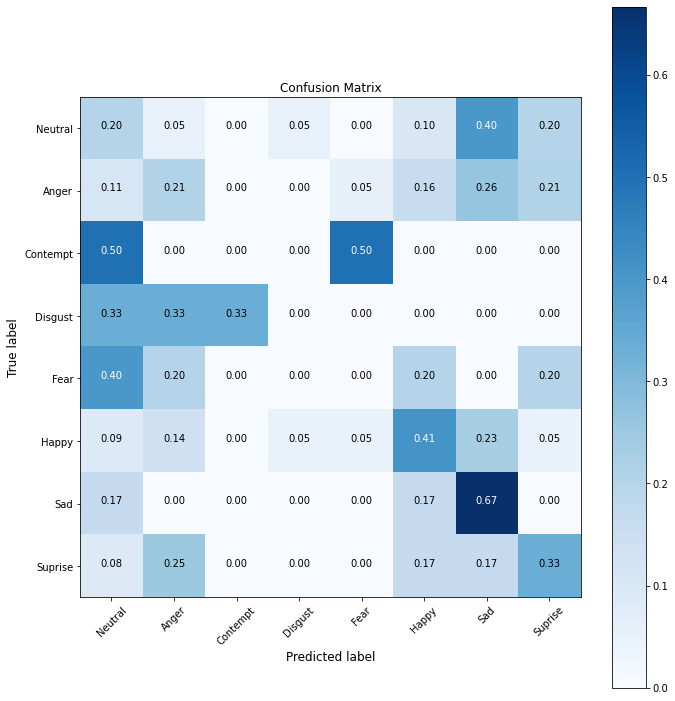

In [ ]:
matrix = confusion_matrix(y_test_fine,ans)
plot_confusion_matrix(
        matrix,
        classes=class_names,
        normalize=True,
        title='Confusion Matrix')

In [ ]:
ans = np.argmax(c3d.predict(X_test),axis=-1)
y_test_c3d = np.argmax(y_test,axis=1)


Normalized confusion matrix
[[0.2        0.25       0.         0.         0.         0.5
  0.05       0.        ]
 [0.10526316 0.52631579 0.         0.         0.         0.36842105
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.5        0.        ]
 [0.         0.33333333 0.         0.         0.         0.66666667
  0.         0.        ]
 [0.         0.4        0.         0.         0.         0.6
  0.         0.        ]
 [0.04545455 0.31818182 0.         0.         0.         0.63636364
  0.         0.        ]
 [0.16666667 0.33333333 0.         0.         0.         0.33333333
  0.16666667 0.        ]
 [0.08333333 0.41666667 0.         0.08333333 0.         0.41666667
  0.         0.        ]]


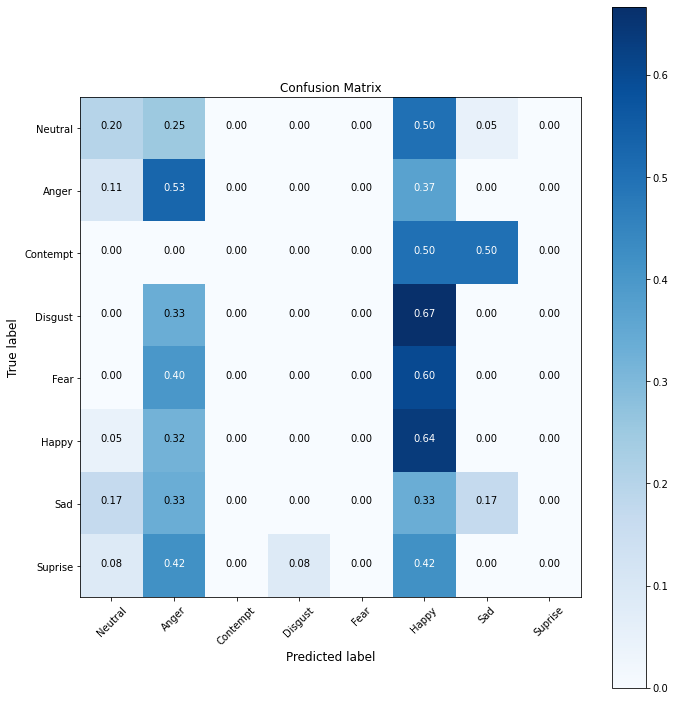

In [ ]:
matrix = confusion_matrix(y_test_c3d,ans)
plot_confusion_matrix(
        matrix,
        classes=class_names,
        normalize=True,
        title='Confusion Matrix')

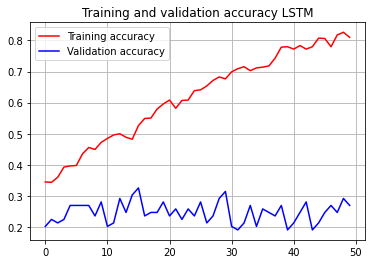

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy LSTM')
plt.legend(loc=0)
plt.grid()
plt.show()

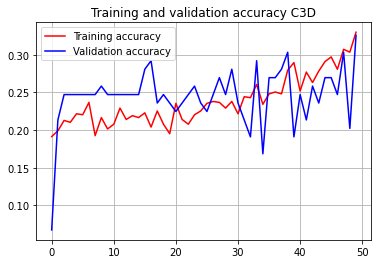

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy C3D')
plt.legend(loc=0)
plt.grid()
plt.show()

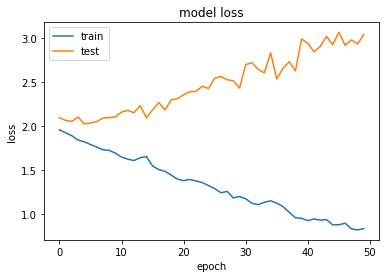

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

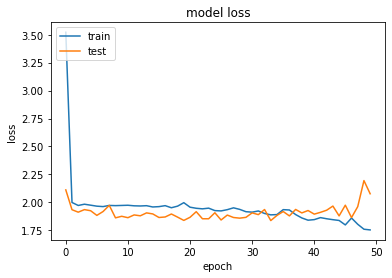

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()